In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 71ms/step - loss: 0.1155 - val_loss: 0.0176
Epoch 2/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0128 - val_loss: 0.0270
Epoch 3/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0099 - val_loss: 0.0288
Epoch 4/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0091 - val_loss: 0.0234
Epoch 5/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0080 - val_loss: 0.0176
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0071 - val_loss: 0.0116
Epoch 7/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0069 - val_loss: 0.0123
Epoch 8/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0062 - val_loss: 0.0120
Epoch 9/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0053 - val_loss: 0.0138
Epoch 10/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0052 - val_loss: 0.0095

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 9ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 30.680251690542203
Testing RMSE: 44.10226309897206


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.04200138 0.06380537 0.06105118 0.08790452 0.10121643 0.10420014
 0.11361028 0.12370897 0.11957769 0.10787239 0.08974065 0.08078953
 0.09915079 0.12324994 0.11521689 0.11016755 0.11911866 0.07482213
 0.0700023  0.07711728 0.09570806 0.12141382 0.12439752 0.08698646
 0.09524902 0.07665825 0.06495295 0.06655956 0.08377324 0.08583888
 0.09065871 0.07574019 0.06219876 0.02662382 0.0130824  0.01629562
 0.00550838 0.         0.00068855 0.00986918 0.02983704 0.03442736
 0.02501721 0.01445949 0.0247877  0.03534542 0.05324765 0.04705072
 0.07137939 0.08056002 0.1211843  0.11269222 0.0977737  0.0817076
 0.07413358 0.09478999 0.10236401 0.09823273 0.1007574  0.15193941
 0.1650218  0.17833372 0.18338306 0.18820289 0.18200597 0.18154694
 0.17489098 0.17098921 0.16341519 0.16593987 0.16043149 0.16616938
 0.1590544  0.14344733 0.13679137 0.12393849 0.10924948 0.09134726
 0.09524902 0.1138398  0.14138168 0.12393849 0.11177416 0.13197154
 0.14551297 0.13977507 0.13472573 0.11934818 0.1163

ValueError: cannot reshape array of size 101 into shape (1,100,1)

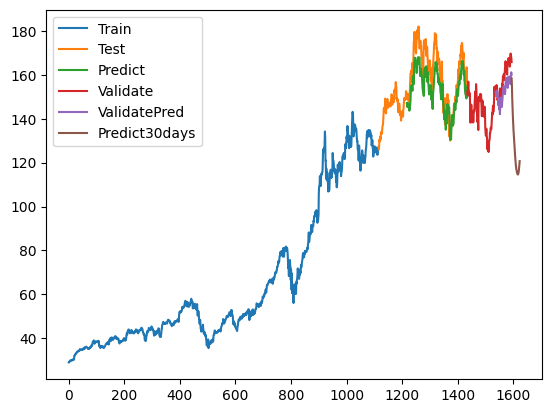

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()